In [1]:
import sys
import os
import torch
import numpy as np
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)
from ssast_model import ASTModel
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchaudio
import pickle
import librosa

## reconstruct spectrogram

In [2]:
# function to reconstruct audio from mel spectrogram
def mel_2_audio(M):

    # print shape and type of input
    print("shape of mel spectrogram:", M.shape, "type of mel spectrogram:", M.dtype)

    sr = 16000
    n_fft = 400
    hop_length = int(0.01 * sr)  # 10 ms
    win_length = int(0.025 * sr)  # 25 ms (= n_fft) 
    window = 'hanning'

    # convert to linear scale
    linear_M = np.exp(M)

    # reconstruct audio
    audio = librosa.feature.inverse.mel_to_audio(linear_M, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, n_iter=50, htk=True) 

    # print shape and type of output
    print("shape of reconstructed audio:", audio.shape, "type of reconstructed audio:", audio.dtype)

    return audio

In [ ]:
def adjust_and_synthesize_audio(audiosignal, torchaudio_spectrogram_to_fit, torchaudio_spectrogram_to_adjust, sample_rate):
    
    def fit_polynomial_transform(M1, M2, order=5):
        b = M1 - M2
        f_bins, t_frames = M1.shape
        f = np.repeat(np.arange(f_bins), t_frames)
        # Create polynomial features up to the given order
        A = np.column_stack([f**i for i in range(order + 1)])
        b = b.flatten()
        A_transpose = A.T
        A_transpose_A = np.dot(A_transpose, A)
        A_transpose_b = np.dot(A_transpose, b)
        x = np.linalg.solve(A_transpose_A, A_transpose_b)
        return x  # coefficients of the polynomial

    def mel_2_audio(M):
        sr = sample_rate
        n_fft = 400
        hop_length = int(0.01 * sr)  # 10 ms
        win_length = int(0.025 * sr)  # 25 ms (= n_fft)
        window = 'hanning'
        linear_M = librosa.db_to_power(M)
        audio = librosa.feature.inverse.mel_to_audio(linear_M, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, n_iter=50, htk=True)
        return audio

    librosa_spectrogram_linear = librosa.feature.melspectrogram(
        y=audiosignal,
        sr=sample_rate,
        n_mels=128,
        hop_length=160,  # 10 ms = 160 * 1/16000
        n_fft=400,       # 25 ms = 400 * 1/16000
        center=False,
        htk=True,
        fmin=0.0,
        fmax=sample_rate / 2  # default Nyquist frequency
    )

    torchaudio_spectrogram_to_fit_linear = np.exp(torchaudio_spectrogram_to_fit)
    torchaudio_spectrogram_to_adjust_linear = np.exp(torchaudio_spectrogram_to_adjust)

    torchaudio_spectrogram_to_fit_db = librosa.power_to_db(torchaudio_spectrogram_to_fit_linear)
    torchaudio_spectrogram_to_adjust_db = librosa.power_to_db(torchaudio_spectrogram_to_adjust_linear)
    librosa_spectrogram_linear_db = librosa.power_to_db(librosa_spectrogram_linear)

    # Calculate the polynomial transformation parameters
    coefficients = fit_polynomial_transform(np.array(librosa_spectrogram_linear_db), np.array(torchaudio_spectrogram_to_fit_db))

    # Apply the polynomial transformation to each frequency bin across all time frames
    frequency_indices = np.arange(torchaudio_spectrogram_to_adjust_db.shape[0]).reshape(-1, 1)
    adjustments = sum([coefficients[i] * frequency_indices**i for i in range(len(coefficients))])
    adjustments = np.tile(adjustments, (1, torchaudio_spectrogram_to_adjust_db.shape[1]))
    adjusted_spectrogram_db = torchaudio_spectrogram_to_adjust_db + adjustments

    # Resynthesize the audio from the adjusted spectrogram
    audio = mel_2_audio(adjusted_spectrogram_db)

    return audio, adjusted_spectrogram_db

### speech

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])
Shape of fbank features: torch.Size([1, 998, 128])
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
cpu
range(50, 489, 50)
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156

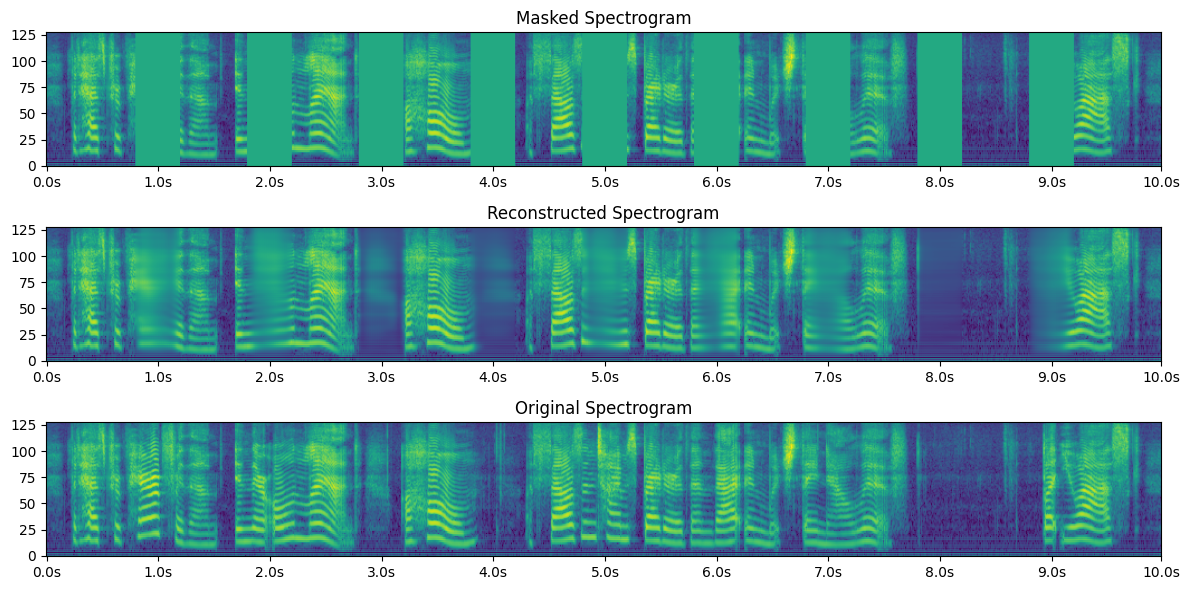

shape of mel spectrogram: (128, 998) type of mel spectrogram: float32


/home/bosfab01/.local/lib/python3.10/site-packages/librosa/feature/inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


shape of reconstructed audio: (159520,) type of reconstructed audio: float32
shape of mel spectrogram: (128, 998) type of mel spectrogram: float32
shape of reconstructed audio: (159520,) type of reconstructed audio: float32
shape of mel spectrogram: (128, 998) type of mel spectrogram: float32
shape of reconstructed audio: (159520,) type of reconstructed audio: float32


In [3]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Save original audio to a WAV file
directory = 'audios'
if not os.path.exists(directory):
    os.makedirs(directory)
output_path_original_audio = 'audios/raw_speech.wav'
sf.write(output_path_original_audio, audio_signal, sample_rate)

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")
test_input = fbank_features

# normalize fbank features
dataset_mean=-3.6925695
dataset_std=4.020388
test_input = (test_input - dataset_mean) / (2 * dataset_std)

# add batch dimension
test_input = test_input.unsqueeze(0)
print(f"Shape of fbank features: {test_input.shape}")


model = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014/models/audio_model.194.pth'))
model = model.module
model.to('cpu')
model.eval()
print(next(model.parameters()).device)  # Should print 'cpu'


hop_width = 20
hop_length = 50 # just for visualization, not the actual hop length used in the data preparation
hops = range(hop_length, 998//2 - hop_width//2, hop_length)
print(hops)
mask_indices = [range(i-hop_width//2, i + hop_width//2) for i in hops]
mask_indices = [idx for group in mask_indices for idx in group]
print(mask_indices)

# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

# Create a mask for the spectrogram
mask = torch.ones_like(test_input)
for idx in expanded_mask_indices:
    mask[0, idx, :] = 0  # Set the specific patches to 0

# Apply the mask to the input spectrogram
masked_spectrogram = test_input * mask

# turn into tensor
mask_indices = torch.tensor(mask_indices)

# Call the model
with torch.no_grad():
    reconstructed_spectrogram = model(test_input, task='visualize_mask', mask_indices=mask_indices)

# compare input and output
print(test_input.shape)
print(reconstructed_spectrogram.shape)

# Assuming 'test_input' is your spectrogram tensor
n_timesteps = test_input.shape[1]  # 998
time_per_step = 10 / 1000  # Example: if each step represents 10 ms (adjust based on your actual data setup)

# Creating time labels for every 100 steps (1 second if each step is 10 ms)
# round timesteps to next 100 and get the range
x_ticks = np.arange(0, n_timesteps, 100)
last_tick = int(np.ceil(n_timesteps / 100) * 100)
x_ticks = np.append(x_ticks, last_tick)
 # formatting time labels as strings in seconds
x_labels = [f"{x * time_per_step:.1f}s" for x in x_ticks]
x_ticks[-1] = n_timesteps

print("x_ticks:", x_ticks)
print("x_labels:", x_labels)


# y-ticks for the frequency axis
y_ticks = np.arange(0, 128, 25)

# Now plotting all three: original input, masked input, and reconstructed output
plt.figure(figsize=(12, 6))

# Define the patch width and height
patch_height = test_input.shape[2]  # This is the vertical height of your spectrogram

# create numpy arrays
masked_spectrogram = masked_spectrogram[0].cpu().numpy().T
reconstructed_spectrogram = reconstructed_spectrogram[0].cpu().numpy().T
test_input = test_input[0].cpu().numpy().T

# unnormalize
masked_spectrogram = masked_spectrogram * (2 * dataset_std) + dataset_mean
reconstructed_spectrogram = reconstructed_spectrogram * (2 * dataset_std) + dataset_mean
test_input = test_input * (2 * dataset_std) + dataset_mean

# print shapes
print(masked_spectrogram.shape)
print(reconstructed_spectrogram.shape)
print(test_input.shape)

ax1 = plt.subplot(3, 1, 1)
plt.imshow(masked_spectrogram, aspect='auto', origin='lower')
plt.title('Masked Spectrogram')
plt.xticks(x_ticks, x_labels)
plt.yticks(y_ticks)

ax2 = plt.subplot(3, 1, 2)
plt.imshow(reconstructed_spectrogram, aspect='auto', origin='lower')
plt.title('Reconstructed Spectrogram')
plt.xticks(x_ticks, x_labels)
plt.yticks(y_ticks)

ax3 = plt.subplot(3, 1, 3)
plt.imshow(test_input, aspect='auto', origin='lower')
plt.title('Original Spectrogram')
plt.xticks(x_ticks, x_labels) 
plt.yticks(y_ticks)

plt.tight_layout()

plt.show()


# convert back to wav

y_masked = mel_2_audio(masked_spectrogram)
y_reconstructed = mel_2_audio(reconstructed_spectrogram)
y_original = mel_2_audio(test_input)


# save audio
directory = 'audios'
if not os.path.exists(directory):
    os.makedirs(directory)
output_path_masked_audio = 'audios/masked_speech.wav'
output_path_reconstructed_audio = 'audios/reconstructed_speech.wav' 
output_path_original_audio = 'audios/original_speech.wav'
sr = 16000
sf.write(output_path_masked_audio, y_masked, sr)
sf.write(output_path_reconstructed_audio, y_reconstructed, sr)
sf.write(output_path_original_audio, y_original, sr)

### music

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459]
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dime

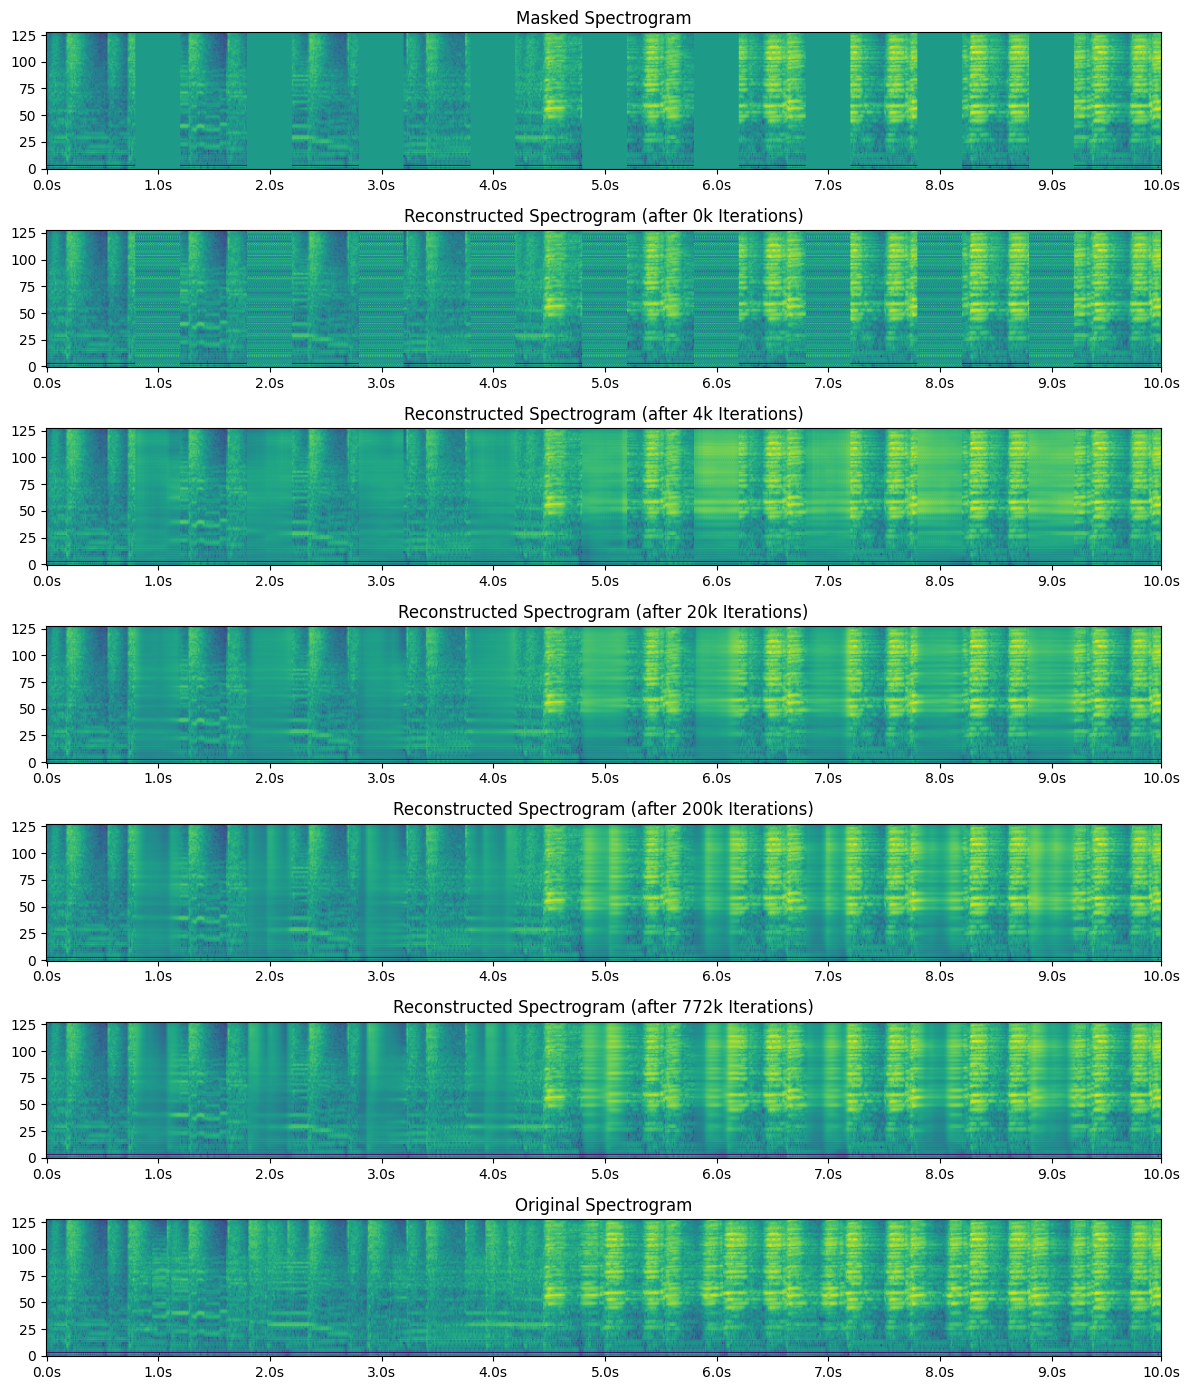

In [4]:
# Verify the file path is correct
#file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed_eval/1a281f7d-bde7-4744-9220-7ea599b6e093/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Save original audio to a WAV file
directory = 'audios'
if not os.path.exists(directory):
    os.makedirs(directory)
output_path_original_audio = 'audios/raw_music.wav'
sf.write(output_path_original_audio, audio_signal, sample_rate)

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
test_input = fbank_features

# normalize fbank features
dataset_mean=-3.6925695
dataset_std=4.020388
test_input = (test_input - dataset_mean) / (2 * dataset_std)

# add batch dimension
test_input = test_input.unsqueeze(0)

width = 20
hop_length = 50 # just for visualization, not the actual hop length used in the data preparation
hops = range(hop_length, 998//2 - width//2, hop_length)
mask_indices = [range(i-width//2, i + width//2) for i in hops]
mask_indices = [idx for group in mask_indices for idx in group]
print(mask_indices)

# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

# Create a mask for the spectrogram
mask = torch.ones_like(test_input)
for idx in expanded_mask_indices:
    mask[0, idx, :] = 0  # Set the specific patches to 0

# Apply the mask to the input spectrogram
masked_spectrogram = test_input * mask

# turn into tensor
mask_indices = torch.tensor(mask_indices)

# Assuming 'test_input' is your spectrogram tensor
n_timesteps = test_input.shape[1]  # 998
time_per_step = 10 / 1000  # Example: if each step represents 10 ms (adjust based on your actual data setup)

# Creating time labels for every 100 steps (1 second if each step is 10 ms)
# round timesteps to next 100 and get the range
x_ticks = np.arange(0, n_timesteps, 100)
last_tick = int(np.ceil(n_timesteps / 100) * 100)
x_ticks = np.append(x_ticks, last_tick)
 # formatting time labels as strings in seconds
x_labels = [f"{x * time_per_step:.1f}s" for x in x_ticks]
x_ticks[-1] = n_timesteps


# y-ticks for the frequency axis
y_ticks = np.arange(0, 128, 25)


def initialize_model():
    return ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)

def load_model(checkpoint_id):
    model = initialize_model()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(f'/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014/models/audio_model.{checkpoint_id}.pth'))
    model = model.module
    model.to('cpu')
    model.eval()
    return model

# Load models
models = {i: load_model(i) for i in [1, 2, 6, 51, 194]}

# Generate spectrograms
with torch.no_grad():
    reconstructed_spectrograms = {i: model(test_input, task='visualize_mask', mask_indices=mask_indices) for i, model in models.items()}

# Plotting
plt.figure(figsize=(12, 14))

def plot_spectrogram(data, title, position):         
    plt.subplot(7, 1, position)
    plt.imshow(data[0].cpu().numpy().T, aspect='auto', origin='lower')
    plt.title(title)
    plt.xticks(x_ticks, x_labels)
    plt.yticks(y_ticks)

def convert_and_save_audio(data, output_path):
    M_normalized = data[0].cpu().numpy().T
    M_unnormalized = M_normalized * (2 * dataset_std) + dataset_mean
    y = mel_2_audio(M_unnormalized)
    sr = 16000
    sf.write(output_path, y, sr)

# masked spectrogram
plot_spectrogram(masked_spectrogram, 'Masked Spectrogram', 1)
convert_and_save_audio(masked_spectrogram, 'audios/masked_music.wav')

# reconstructed spectrograms
for index, checkpoint in enumerate(sorted(reconstructed_spectrograms.keys())):
    plot_spectrogram(reconstructed_spectrograms[checkpoint], f'Reconstructed Spectrogram (after {(checkpoint-1)*4}k Iterations)', index + 2)
    convert_and_save_audio(reconstructed_spectrograms[checkpoint], f'audios/reconstructed_music_{checkpoint}.wav')

# original spectrogram
plot_spectrogram(test_input, 'Original Spectrogram', 7)
convert_and_save_audio(test_input, 'audios/original_music.wav')

plt.tight_layout()

plt.show()